<a href="https://colab.research.google.com/github/MittalNeha/retinopathy-kaggle/blob/master/Xception_basemodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import (Activation, Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D,
                          Dense, BatchNormalization, GlobalAveragePooling2D)
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.losses import binary_crossentropy, categorical_crossentropy

from keras.applications.xception import Xception

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from keras import metrics
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils import class_weight, shuffle
import cv2
from keras import backend as K
import tensorflow as tf

from tqdm import tqdm

color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def get_kaggle_data():
  os.environ['KAGGLE_USERNAME'] = "mittalneha"
  os.environ['KAGGLE_KEY'] = "59ec3f992f5fb4b510bebd8dea889381"
  
  !kaggle competitions download -c aptos2019-blindness-detection
#   !kaggle datasets download -d keras/resnet50
#   !kaggle datasets download -d keras/xception
  
  !mkdir kaggle-data
  !mv sample_submission.csv kaggle-data/
  !mv test.csv kaggle-data/
  !mv train.csv kaggle-data/
  !unzip test_images.zip -d kaggle-data/test_images
#   !unzip train_images.zip -d kaggle-data/train_images
  !cp /content/gdrive/My\ Drive/Colab\ Notebooks/aug_train_images.zip .
  !cp /content/gdrive/My\ Drive/Colab\ Notebooks/aug_train.csv .
  
  !cp /content/gdrive/My\ Drive/Colab\ Notebooks/xception_aug2.zip .
  
  !unzip aug_train_images.zip
  !mv aug_train_images kaggle-data/
  !mv aug_train.csv kaggle-data/
  
  !unzip xception_aug2.zip
  !mkdir kaggle-data/xception
#   !unzip xception.zip -d kaggle-data/xception/  

In [4]:
data_dir = "kaggle-data"
get_kaggle_data()

100% 8.01G/8.01G [01:54<00:00, 79.8MB/s]
100% 8.01G/8.01G [01:54<00:00, 75.1MB/s]
 99% 1.49G/1.50G [00:44<00:00, 52.7MB/s]
100% 1.50G/1.50G [00:44<00:00, 36.5MB/s]
  0% 0.00/53.7k [00:00<?, ?B/s]
100% 53.7k/53.7k [00:00<00:00, 49.9MB/s]
  0% 0.00/24.5k [00:00<?, ?B/s]
100% 24.5k/24.5k [00:00<00:00, 20.2MB/s]
  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 22.9MB/s]
Archive:  test_images.zip
  inflating: kaggle-data/test_images/270a532df702.png  
  inflating: kaggle-data/test_images/86fd5df366b2.png  
  inflating: kaggle-data/test_images/72dd7ca97f55.png  
  inflating: kaggle-data/test_images/ec8f3ec97245.png  
  inflating: kaggle-data/test_images/b3db392f5ee8.png  
  inflating: kaggle-data/test_images/c71728f9535b.png  
  inflating: kaggle-data/test_images/c7c003cdaaba.png  
  inflating: kaggle-data/test_images/67b614d32bcc.png  
  inflating: kaggle-data/test_images/e982c6b5b726.png  
  inflating: kaggle-data/test_images/e2fdc91493f4.png  
  inflating: kaggle-data/test_i

In [0]:
!mv xception* kaggle-data/xception/
# !mv xception kaggle-data/xception/

In [0]:
WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
SIZE = 300
NUM_CLASSES = 5

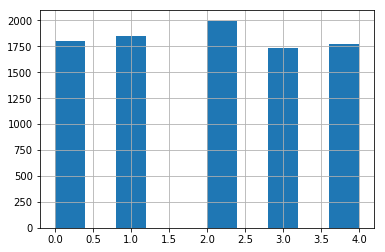

In [7]:
df_train = pd.read_csv('kaggle-data/aug_train.csv')
df_test = pd.read_csv('kaggle-data/test.csv')

df_train.columns = ['id_code', 'diagnosis']

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=8)
y.hist()


In [8]:
y = to_categorical(y, num_classes=NUM_CLASSES)
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=8)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(7785,)
(7785, 5)
(1374,)
(1374, 5)


In [0]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=True,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('kaggle-data/aug_train_images/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
#             if(self.is_augment):
#                 img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('kaggle-data/aug_train_images/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

In [0]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = Xception(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
#     base_model.load_weights('kaggle-data/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    model.load_weights('kaggle-data/xception/xception-10-0.02.h5')
    
    return model

In [0]:
!mkdir 'kaggle-data/model'

In [0]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 10; batch_size = 16
checkpoint = ModelCheckpoint('kaggle-data/model/xception-{epoch:02d}-{loss:.4f}.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)

csv_logger = CSVLogger(filename='kaggle-data/model/training_log.csv',
                       separator=',',
                       append=True)
# callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early]

train_generator = My_Generator(train_x, train_y, 128, is_train=True)
train_mixup = My_Generator(train_x, train_y, batch_size, is_train=True, mix=False, augment=True)
valid_generator = My_Generator(valid_x, valid_y, batch_size, is_train=False)

model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES)

In [0]:
# reference link: https://www.kaggle.com/christofhenkel/weighted-kappa-loss-for-keras-tensorflow
def kappa_loss(y_true, y_pred, y_pow=2, eps=1e-12, N=5, bsize=32, name='kappa'):
    """A continuous differentiable approximation of discrete kappa loss.
        Args:
            y_pred: 2D tensor or array, [batch_size, num_classes]
            y_true: 2D tensor or array,[batch_size, num_classes]
            y_pow: int,  e.g. y_pow=2
            N: typically num_classes of the model
            bsize: batch_size of the training or validation ops
            eps: a float, prevents divide by zero
            name: Optional scope/name for op_scope.
        Returns:
            A tensor with the kappa loss."""

    with tf.name_scope(name):
        y_true = tf.to_float(y_true)
        repeat_op = tf.to_float(tf.tile(tf.reshape(tf.range(0, N), [N, 1]), [1, N]))
        repeat_op_sq = tf.square((repeat_op - tf.transpose(repeat_op)))
        weights = repeat_op_sq / tf.to_float((N - 1) ** 2)
    
        pred_ = y_pred ** y_pow
        try:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [-1, 1]))
        except Exception:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [bsize, 1]))
    
        hist_rater_a = tf.reduce_sum(pred_norm, 0)
        hist_rater_b = tf.reduce_sum(y_true, 0)
    
        conf_mat = tf.matmul(tf.transpose(pred_norm), y_true)
    
        nom = tf.reduce_sum(weights * conf_mat)
        denom = tf.reduce_sum(weights * tf.matmul(
            tf.reshape(hist_rater_a, [N, 1]), tf.reshape(hist_rater_b, [1, N])) /
                              tf.to_float(bsize))
    
        return nom*0.5 / (denom + eps) + categorical_crossentropy(y_true, y_pred)*0.5

In [0]:
from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            
            score = cohen_kappa_score(flatten(self.y_val),
                                      flatten(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('kaggle-data/model/xception_qwk-{0:04d}-{1:.2f}.h5'.format(epoch, score))

qwk = QWKEvaluation(validation_data=(valid_generator, valid_y),
                    batch_size=batch_size, interval=1)

In [16]:
# warm up model
for layer in model.layers:
    layer.trainable = False

for i in range(-3,0):
    model.layers[i].trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-3))

model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_y)) / float(128)),
    epochs=2,
    workers=WORKERS, use_multiprocessing=True,
    verbose=1,
    callbacks=[qwk])

W0806 06:21:46.848448 139798609852288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0806 06:21:46.982703 139798609852288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
86/86 [==============================] - 36s 420ms/step

 epoch: 1 - QWK_score: 0.968674 

saving checkpoint:  0.9686737218229134
Epoch 2/2
86/86 [==============================] - 32s 372ms/step

 epoch: 2 - QWK_score: 0.969935 

saving checkpoint:  0.9699354399677036


In [19]:
# train all layers
for layer in model.layers:
    layer.trainable = True

callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, qwk]
model.compile(
    #loss='categorical_crossentropy',
             loss=kappa_loss,
            optimizer=Adam(lr=1e-4))

history = model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    workers=1, use_multiprocessing=False,
    callbacks=callbacks_list)

Epoch 1/10
487/487 [==============================] - 691s 1s/step - loss: 0.0417 - val_loss: 0.3952

Epoch 00001: val_loss improved from inf to 0.39523, saving model to kaggle-data/model/xception-01-0.04.h5
86/86 [==============================] - 32s 375ms/step

 epoch: 1 - QWK_score: 0.946118 

saving checkpoint:  0.9461178802201262
Epoch 2/10
487/487 [==============================] - 682s 1s/step - loss: 0.0401 - val_loss: 0.2944

Epoch 00002: val_loss improved from 0.39523 to 0.29437, saving model to kaggle-data/model/xception-02-0.04.h5
86/86 [==============================] - 30s 350ms/step

 epoch: 2 - QWK_score: 0.945193 

Epoch 3/10
487/487 [==============================] - 682s 1s/step - loss: 0.0274 - val_loss: 0.2679

Epoch 00003: val_loss improved from 0.29437 to 0.26787, saving model to kaggle-data/model/xception-03-0.03.h5
86/86 [==============================] - 30s 350ms/step

 epoch: 3 - QWK_score: 0.971040 

saving checkpoint:  0.9710403210870574
Epoch 4/10
487/48

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
all_scores = []
for i, name in tqdm(enumerate(valid_x)):
  path = os.path.join('kaggle-data/aug_train_images/', name+'.png')
  image = cv2.imread(path)
  image = cv2.resize(image, (SIZE, SIZE))

  scores = model.evaluate((image[np.newaxis])/255, np.reshape(valid_y[i], (1,5)), verbose=0)
  all_scores.append(scores)

mean = np.mean(all_scores, axis=0)
sd = np.std(all_scores, axis=0)
print("Loss:    %.2f%% (+/- %.2f%%)" % (mean[0], sd[0]))
print("Accuracy:%.2f%% (+/- %.2f%%)" % (mean[1], sd[1]))

In [0]:
def check_model(hist):
  
  #Plot the curves
  N = len(hist.history['loss'])
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")
 
  plt.title("Training Loss on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  
  
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, N), hist.history["lr"], label="learning_rate")
 
  plt.title("Learning Rate on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("LR")
  plt.legend(loc="lower left")
  
  
  #confusion matrix
  preds = []
  for i, name in tqdm(enumerate(valid_x)):
      path = os.path.join('kaggle-data/aug_train_images/', name+'.png')
      image = cv2.imread(path)
  #     print(str(path))
      image = cv2.resize(image, (SIZE, SIZE))
      score_predict = model.predict((image[np.newaxis])/255)
      label_predict = np.argmax(score_predict)
      preds.append(label_predict)

  valid_labels = np.argmax(valid_y, axis=-1)
  
  cm  = confusion_matrix(valid_labels, preds)
  plt.figure()
  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues, show_normed=True, show_absolute=False)
  plt.show()

1374it [00:58, 23.46it/s]


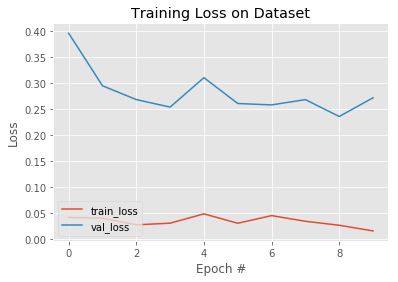

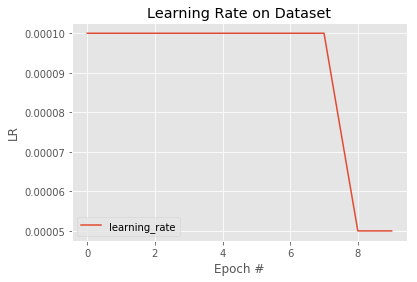

<Figure size 432x288 with 0 Axes>

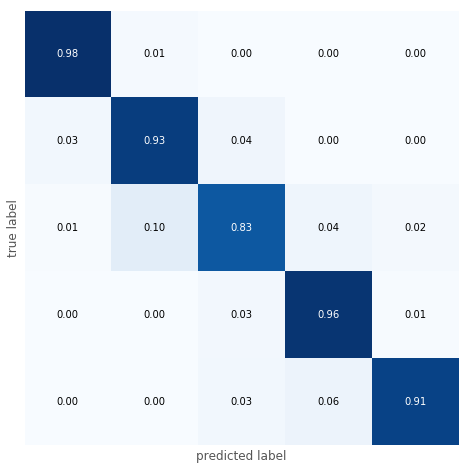

In [41]:
check_model(history)

In [33]:
%cd kaggle-data/model/

/content/kaggle-data/model


In [34]:
!zip xception_aug3.zip training_log.csv xception-09-0.03.h5 xception_qwk-0002-0.97.h5

  adding: training_log.csv (deflated 45%)
  adding: xception-09-0.03.h5 (deflated 7%)
  adding: xception_qwk-0002-0.97.h5 (deflated 8%)


In [0]:
!cp xception_aug3.zip /content/gdrive/My\ Drive/Colab\ Notebooks/

In [36]:
%cd ../../

/content


In [67]:
model.metrics_names

['loss', 'acc']